In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')


from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import warnings
warnings.filterwarnings("ignore")




In [2]:
df=pd.read_csv("CC_LCL-FullData.csv")

In [3]:
# Identify the first 500 unique LCLid values
unique_ids = df['LCLid'].unique()[:500]

# Filter the DataFrame to include only rows with those 500 unique LCLid values
df_500 = df[df['LCLid'].isin(unique_ids)]

# Display the first few rows of the new DataFrame
print(df_500.head())

       LCLid stdorToU                     DateTime KWH/hh (per half hour) 
0  MAC000002      Std  2012-10-12 00:30:00.0000000                      0 
1  MAC000002      Std  2012-10-12 01:00:00.0000000                      0 
2  MAC000002      Std  2012-10-12 01:30:00.0000000                      0 
3  MAC000002      Std  2012-10-12 02:00:00.0000000                      0 
4  MAC000002      Std  2012-10-12 02:30:00.0000000                      0 


In [4]:
df_500.to_csv("energy_data_500.csv")

# loading energy dataset

In [6]:
df=pd.read_csv("energy_data_500.csv")
df.head()

,Unnamed: 0,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,0,MAC000002,Std,2012-10-12 00:30:00.0000000,0
1,1,MAC000002,Std,2012-10-12 01:00:00.0000000,0
2,2,MAC000002,Std,2012-10-12 01:30:00.0000000,0
3,3,MAC000002,Std,2012-10-12 02:00:00.0000000,0
4,4,MAC000002,Std,2012-10-12 02:30:00.0000000,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17311673 entries, 0 to 17311672
Data columns (total 5 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   Unnamed: 0               int64 
 1   LCLid                    object
 2   stdorToU                 object
 3   DateTime                 object
 4   KWH/hh (per half hour)   object
dtypes: int64(1), object(4)
memory usage: 660.4+ MB


# data cleaning

# Convert DateTime column to datetime format

In [10]:
# Convert DateTime column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Extract date only and remove time
df['DateTime'] = df['DateTime'].dt.date

# replacing string NULLL with nan

In [12]:
df['KWH/hh (per half hour) '] = df['KWH/hh (per half hour) '].replace('Null', np.nan)
df=df.dropna(axis=0)
df['KWH/hh (per half hour) ']=df['KWH/hh (per half hour) '].astype(float)

# calculating total energy consumption per month and dropping energy consumption per hour 

In [14]:

# Create a column for year and week
df['YearWeek'] = df['DateTime'].apply(lambda x: x.strftime('%Y-%U'))

# Calculate weekly energy consumption for each LCLid
weekly_consumption = df.groupby(['LCLid', 'YearWeek'])['KWH/hh (per half hour) '].sum().reset_index()
weekly_consumption.rename(columns={'KWH/hh (per half hour) ': 'WeeklyConsumption'}, inplace=True)

# Add start and end date columns
weekly_consumption['StartDate'] = weekly_consumption['YearWeek'].apply(lambda x: pd.to_datetime(x + '-0', format='%Y-%U-%w'))
weekly_consumption['EndDate'] = weekly_consumption['StartDate'] + pd.offsets.Week(weekday=6)

# Drop the YearWeek column as it's no longer needed
weekly_consumption = weekly_consumption.drop(columns=['YearWeek'])

# Display the result
weekly_consumption.head()



,LCLid,WeeklyConsumption,StartDate,EndDate
0,MAC000002,18.185,2012-10-07,2012-10-14
1,MAC000002,80.894,2012-10-14,2012-10-21
2,MAC000002,114.476,2012-10-21,2012-10-28
3,MAC000002,105.301,2012-10-28,2012-11-04
4,MAC000002,84.555,2012-11-04,2012-11-11


# creating new features from date time

In [16]:
# Ensure StartDate and EndDate are in datetime format
weekly_consumption['StartDate'] = pd.to_datetime(weekly_consumption['StartDate'])
weekly_consumption['EndDate'] = pd.to_datetime(weekly_consumption['EndDate'])

# Extract year, month, quarter, start day, end day, and week
weekly_consumption['year'] = weekly_consumption['StartDate'].dt.year
weekly_consumption['month'] = weekly_consumption['StartDate'].dt.month
weekly_consumption['quarter'] = weekly_consumption['StartDate'].dt.quarter
weekly_consumption['start_day'] = weekly_consumption['StartDate'].dt.day
weekly_consumption['end_day'] = weekly_consumption['EndDate'].dt.day
weekly_consumption['week'] = weekly_consumption['StartDate'].dt.isocalendar().week


In [17]:
weekly_consumption.head()

,LCLid,WeeklyConsumption,StartDate,EndDate,year,month,quarter,start_day,end_day,week
0,MAC000002,18.185,2012-10-07,2012-10-14,2012,10,4,7,14,40
1,MAC000002,80.894,2012-10-14,2012-10-21,2012,10,4,14,21,41
2,MAC000002,114.476,2012-10-21,2012-10-28,2012,10,4,21,28,42
3,MAC000002,105.301,2012-10-28,2012-11-04,2012,10,4,28,4,43
4,MAC000002,84.555,2012-11-04,2012-11-11,2012,11,4,4,11,44


# loading informations_households dataset

In [19]:
household_info=pd.read_csv("informations_households.csv")

In [20]:
household_info.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [21]:
# Rename columns
household_info.rename(columns={
    'Acorn_grouped': 'AcornGroup'}, inplace=True)

In [22]:
weekly_consumption

,LCLid,WeeklyConsumption,StartDate,EndDate,year,month,quarter,start_day,end_day,week
0,MAC000002,18.185,2012-10-07,2012-10-14,2012,10,4,7,14,40
1,MAC000002,80.894,2012-10-14,2012-10-21,2012,10,4,14,21,41
2,MAC000002,114.476,2012-10-21,2012-10-28,2012,10,4,21,28,42
3,MAC000002,105.301,2012-10-28,2012-11-04,2012,10,4,28,4,43
4,MAC000002,84.555,2012-11-04,2012-11-11,2012,11,4,4,11,44
...,...,...,...,...,...,...,...,...,...,...
52974,MAC000607,81.101,2013-02-03,2013-02-10,2013,2,1,3,10,5
52975,MAC000607,97.867,2013-02-10,2013-02-17,2013,2,1,10,17,6
52976,MAC000607,57.893,2013-02-17,2013-02-24,2013,2,1,17,24,7
52977,MAC000607,53.563,2013-02-24,2013-03-03,2013,2,1,24,3,8


# merge energy consumption dataset with households dataset

In [24]:
df_final=weekly_consumption.merge(household_info,on='LCLid',how='left')


In [25]:
df_final=df_final[['LCLid', 'WeeklyConsumption', 'StartDate', 'EndDate', 'year', 'month',
       'quarter', 'start_day', 'end_day','week', 'AcornGroup']]
df_final.head()

,LCLid,WeeklyConsumption,StartDate,EndDate,year,month,quarter,start_day,end_day,week,AcornGroup
0,MAC000002,18.185,2012-10-07,2012-10-14,2012,10,4,7,14,40,Affluent
1,MAC000002,80.894,2012-10-14,2012-10-21,2012,10,4,14,21,41,Affluent
2,MAC000002,114.476,2012-10-21,2012-10-28,2012,10,4,21,28,42,Affluent
3,MAC000002,105.301,2012-10-28,2012-11-04,2012,10,4,28,4,43,Affluent
4,MAC000002,84.555,2012-11-04,2012-11-11,2012,11,4,4,11,44,Affluent


# exploratory data analysis

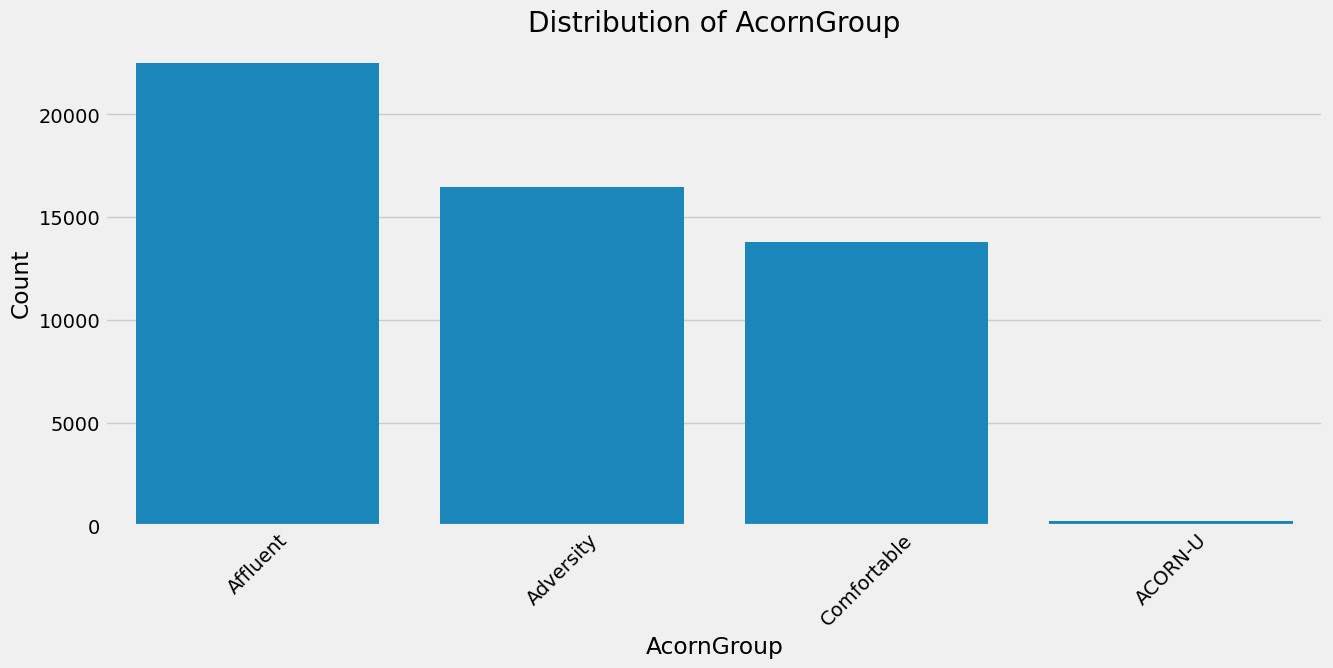

In [27]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df_final, x='AcornGroup', order=df_final['AcornGroup'].value_counts().index)
plt.title('Distribution of AcornGroup')
plt.xlabel('AcornGroup')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

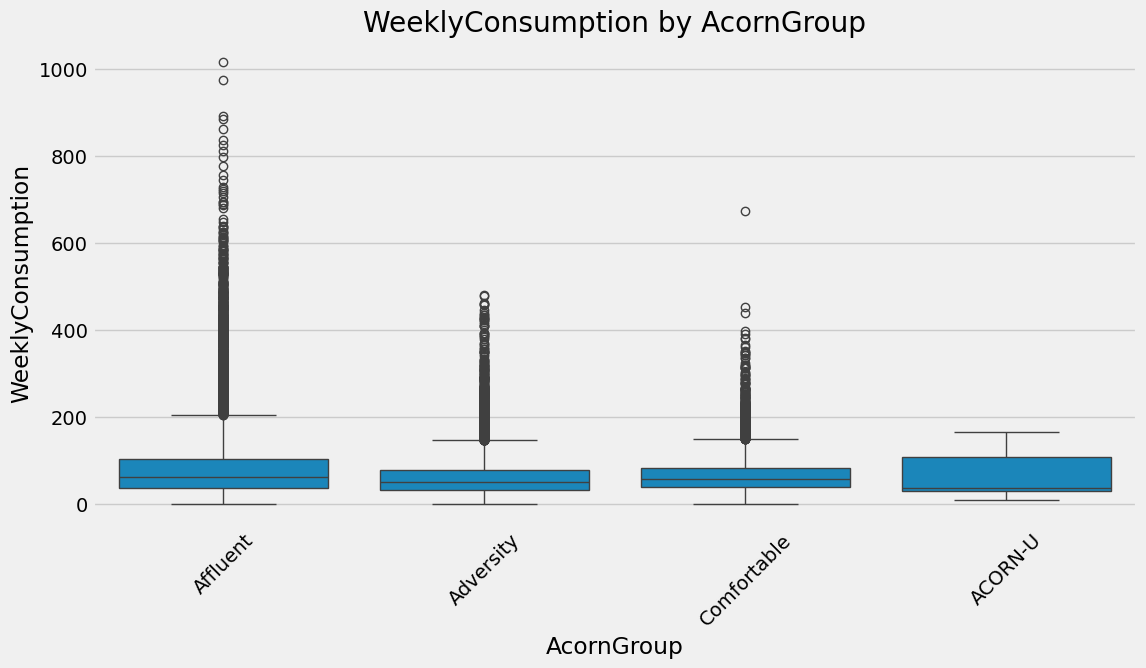

In [28]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_final, x='AcornGroup', y='WeeklyConsumption')
plt.title('WeeklyConsumption by AcornGroup')
plt.xlabel('AcornGroup')
plt.ylabel('WeeklyConsumption')
plt.xticks(rotation=45)
plt.show()

In [29]:


# Calculate descriptive statistics
grouped_stats = df_final.groupby('AcornGroup')['WeeklyConsumption'].agg(['mean', 'median', 'std','min','max', 'count']).reset_index()

# Print the table
print(grouped_stats)


    AcornGroup       mean   median        std    min          max  count
0      ACORN-U  64.219089  36.1540  41.579644  7.274   163.895000    237
1    Adversity  61.395287  50.1380  46.757845  0.000   479.636000  16450
2     Affluent  84.382406  60.3945  80.328498  0.000  1017.029999  22506
3  Comfortable  64.415136  57.1060  40.709735  0.000   672.585000  13786


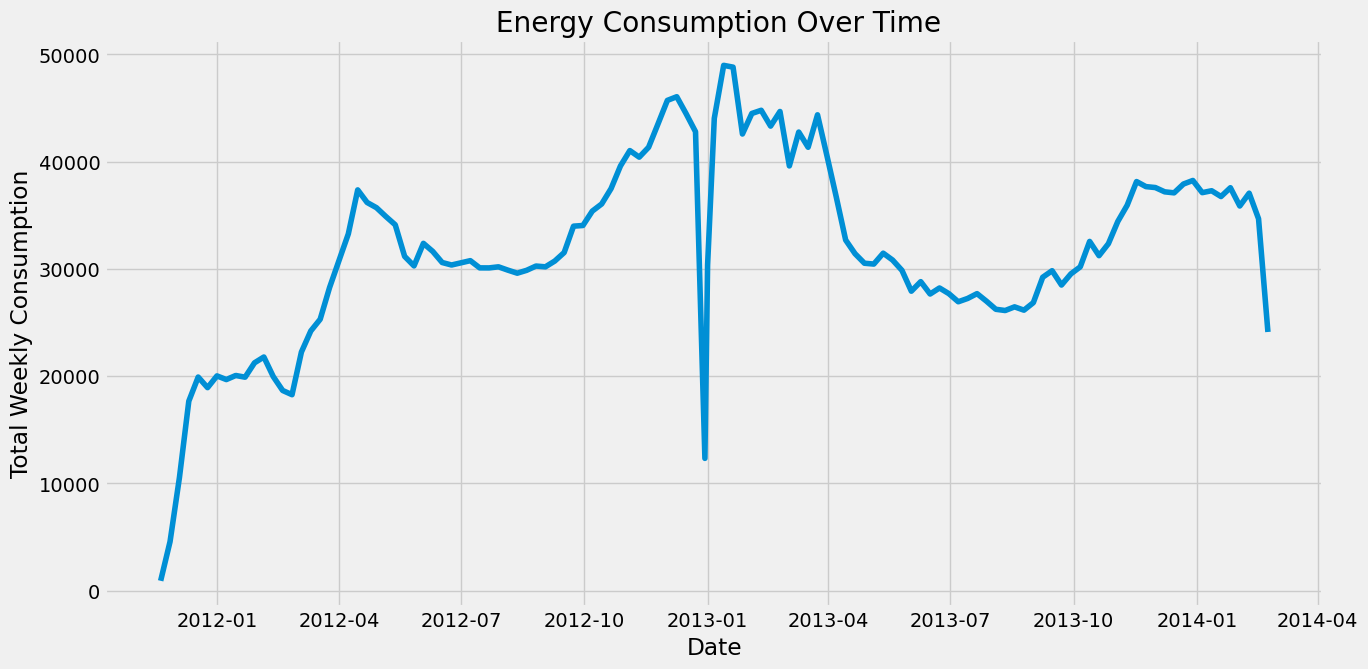

In [30]:
Weekly_Consumption = df_final.groupby('StartDate')['WeeklyConsumption'].sum().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(Weekly_Consumption['StartDate'], Weekly_Consumption['WeeklyConsumption'])
plt.title(' Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Consumption')
plt.show()

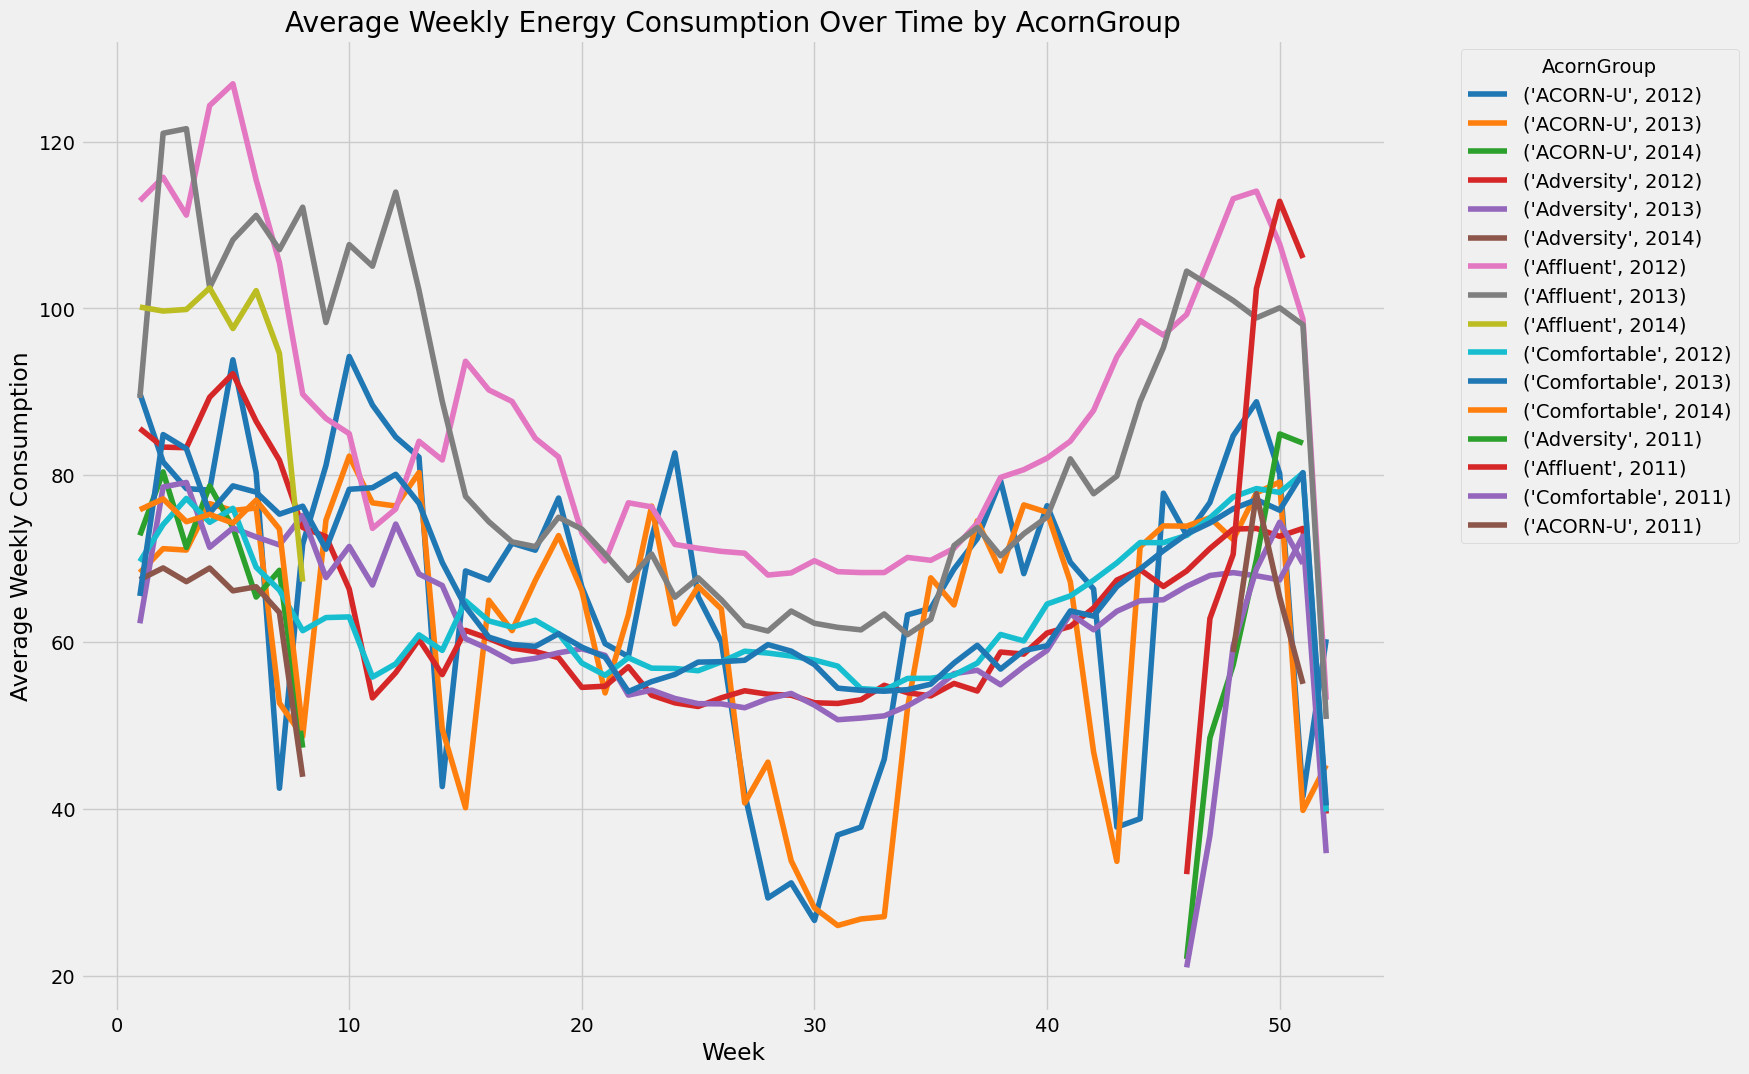

In [31]:

# Aggregate data by date and AcornGroup
grouped_data = df_final.groupby(['week', 'AcornGroup','year'])['WeeklyConsumption'].mean().reset_index()

# Pivot the data to have StartDate as index and AcornGroup as columns
pivot_data = grouped_data.pivot(index='week', columns=['AcornGroup','year'], values='WeeklyConsumption')

# Plotting
plt.figure(figsize=(15, 12))

# Choose a color palette
palette = sns.color_palette("tab10", len(pivot_data.columns))

# Plot each AcornGroup with a different color
for i, group in enumerate(pivot_data.columns):
    plt.plot(pivot_data.index, pivot_data[group], label=group, color=palette[i])

plt.title('Average Weekly Energy Consumption Over Time by AcornGroup')
plt.xlabel('Week')
plt.ylabel('Average Weekly Consumption')

# Adjust the legend
plt.legend(title='AcornGroup', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


       WeeklyConsumption                      StartDate  \
count         119.000000                            119   
mean           46.213924  2013-01-15 20:10:05.042016768   
min            14.634000            2011-12-04 00:00:00   
25%            28.703500            2012-06-27 12:00:00   
50%            56.398000            2013-01-13 00:00:00   
75%            62.481500            2013-08-07 12:00:00   
max            70.038000            2014-02-23 00:00:00   
std            18.872837                            NaN   

                             EndDate         year       month     quarter  \
count                            119   119.000000  119.000000  119.000000   
mean   2013-01-22 19:45:52.941176576  2012.554622    6.386555    2.453782   
min              2011-12-11 00:00:00  2011.000000    1.000000    1.000000   
25%              2012-07-04 12:00:00  2012.000000    3.000000    1.000000   
50%              2013-01-20 00:00:00  2013.000000    6.000000    2.000000   
75%   

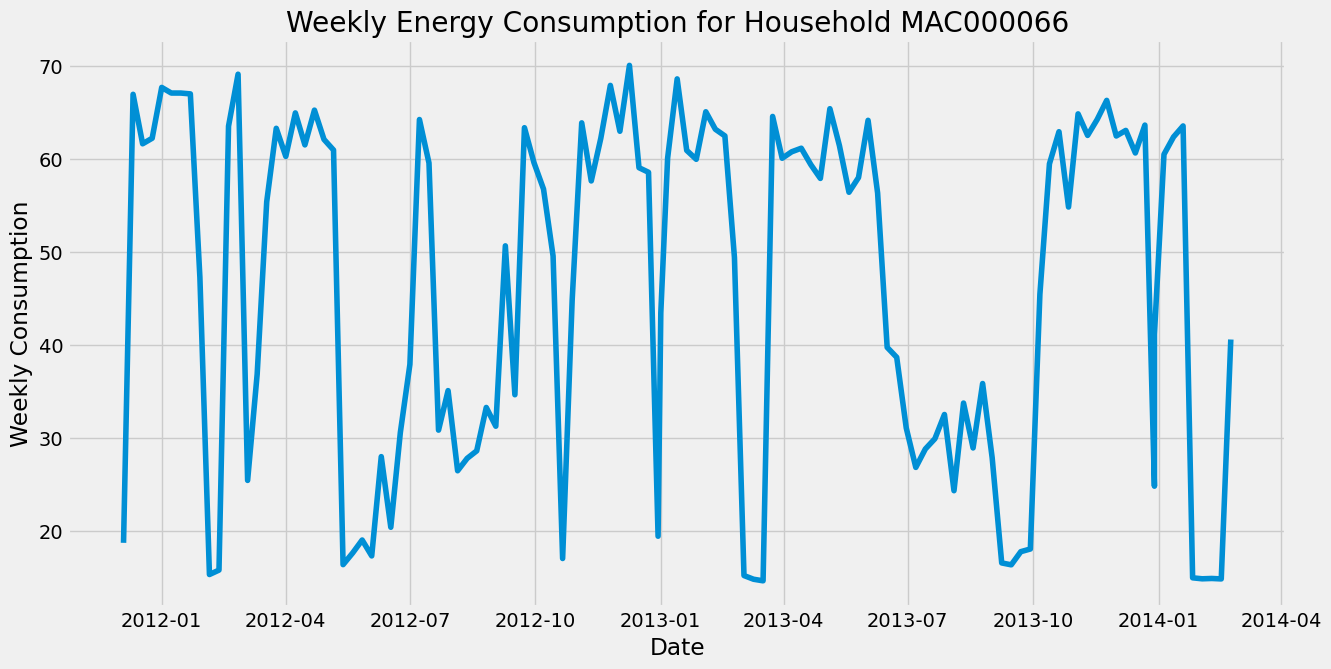

In [32]:
household_id = 'MAC000066'
household_data = df_final[df_final['LCLid'] == household_id]

# Basic statistics for the household
print(household_data.describe())

# Time series plot for the household
plt.figure(figsize=(14, 7))
plt.plot(household_data['StartDate'], household_data['WeeklyConsumption'])
plt.title(f'Weekly Energy Consumption for Household {household_id}')
plt.xlabel('Date')
plt.ylabel('Weekly Consumption')
plt.show()

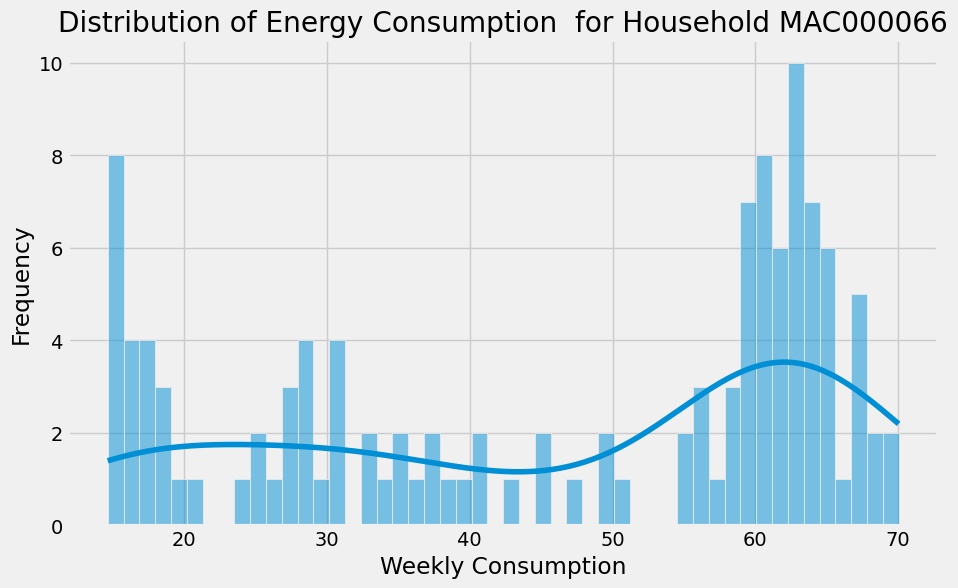

In [33]:
# Distribution of KW_per_day
plt.figure(figsize=(10, 6))
sns.histplot(household_data['WeeklyConsumption'], bins=50, kde=True)
plt.title('Distribution of Energy Consumption  for Household MAC000066')
plt.xlabel('Weekly Consumption')
plt.ylabel('Frequency')
plt.show()


# feature engineering: 
Create the new feature for previous month's energy consumption for each household


In [35]:
# Sort the dataframe by LCLid and StartDate to ensure the shift operation is correct
df_final = df_final.sort_values(by=['LCLid', 'StartDate'])

# Create the new feature for previous month's energy consumption
df_final['PrevweekConsumption'] = df_final.groupby('LCLid')['WeeklyConsumption'].shift(1)
df_final['PrevweekConsumption'].fillna(0, inplace=True)
df_final.head()

,LCLid,WeeklyConsumption,StartDate,EndDate,year,month,quarter,start_day,end_day,week,AcornGroup,PrevweekConsumption
0,MAC000002,18.185,2012-10-07,2012-10-14,2012,10,4,7,14,40,Affluent,0.000
1,MAC000002,80.894,2012-10-14,2012-10-21,2012,10,4,14,21,41,Affluent,18.185
2,MAC000002,114.476,2012-10-21,2012-10-28,2012,10,4,21,28,42,Affluent,80.894
3,MAC000002,105.301,2012-10-28,2012-11-04,2012,10,4,28,4,43,Affluent,114.476
4,MAC000002,84.555,2012-11-04,2012-11-11,2012,11,4,4,11,44,Affluent,105.301


# data preprocessing

In [37]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to the 'original_language' column and transform it
df_final['AcornGroup'] = label_encoder.fit_transform(df_final['AcornGroup'])
print(df_final.head())

       LCLid  WeeklyConsumption  StartDate    EndDate  year  month  quarter  \
0  MAC000002             18.185 2012-10-07 2012-10-14  2012     10        4   
1  MAC000002             80.894 2012-10-14 2012-10-21  2012     10        4   
2  MAC000002            114.476 2012-10-21 2012-10-28  2012     10        4   
3  MAC000002            105.301 2012-10-28 2012-11-04  2012     10        4   
4  MAC000002             84.555 2012-11-04 2012-11-11  2012     11        4   

   start_day  end_day  week  AcornGroup  PrevweekConsumption  
0          7       14    40           2                0.000  
1         14       21    41           2               18.185  
2         21       28    42           2               80.894  
3         28        4    43           2              114.476  
4          4       11    44           2              105.301  


In [38]:
# Splitting data into X and y
X = df_final.drop(["LCLid",'StartDate','EndDate','WeeklyConsumption'], axis=1)
y = df_final["WeeklyConsumption"]


In [39]:
X.columns=X.columns.astype(str)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [41]:

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_train = scaler.fit_transform(X_train)

# Transform the testing data
X_test = scaler.transform(X_test)




In [42]:
def print_evaluate(true, predicted):
    # Mean Absolute Error
    mae = metrics.mean_absolute_error(true, predicted)
    # Mean Squarred Error
    mse = metrics.mean_squared_error(true, predicted)
    # Calculating R2 Score
    r2_score = metrics.r2_score(true, predicted)
    # Calculating RMSE Score
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))

    # Calculating mean_absolute_percentage_error
    mape = metrics.mean_absolute_percentage_error(true, predicted)

    print('Mean Absolute Error', mae)
    print('Mean Squarred Error', mse)
    print('Root Mean Squarred Error', rmse)
    print('mean_absolute_percentage_error', mape)
    print('R2 Score:', r2_score)

def evaluate(true, predicted):

    # Calculating MAE Score
    mae = metrics.mean_absolute_error(true, predicted)
    # Calculatinog MSE Score
    mse = metrics.mean_squared_error(true, predicted)
    # Calculationg R2 Score
    r2_score = metrics.r2_score(true, predicted)
    # Calculating RMSE Score
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))

    mape = metrics.mean_absolute_percentage_error(true, predicted)
    # Return ing Score
    return mae, mse, rmse,mape ,r2_score

# models with default parameters

# model 1: GradientBoostingRegressor

Test Dataset Score

Mean Absolute Error 10.988806550857042
Mean Squarred Error 467.89231351589723
Root Mean Squarred Error 21.63081860484936
mean_absolute_percentage_error 231977725888572.22
R2 Score: 0.8803257842994578

Train Dataset Score

Mean Absolute Error 10.655486224803834
Mean Squarred Error 379.24489404844115
Root Mean Squarred Error 19.47421099938175
mean_absolute_percentage_error 157146832865537.97
R2 Score: 0.9053236528764774


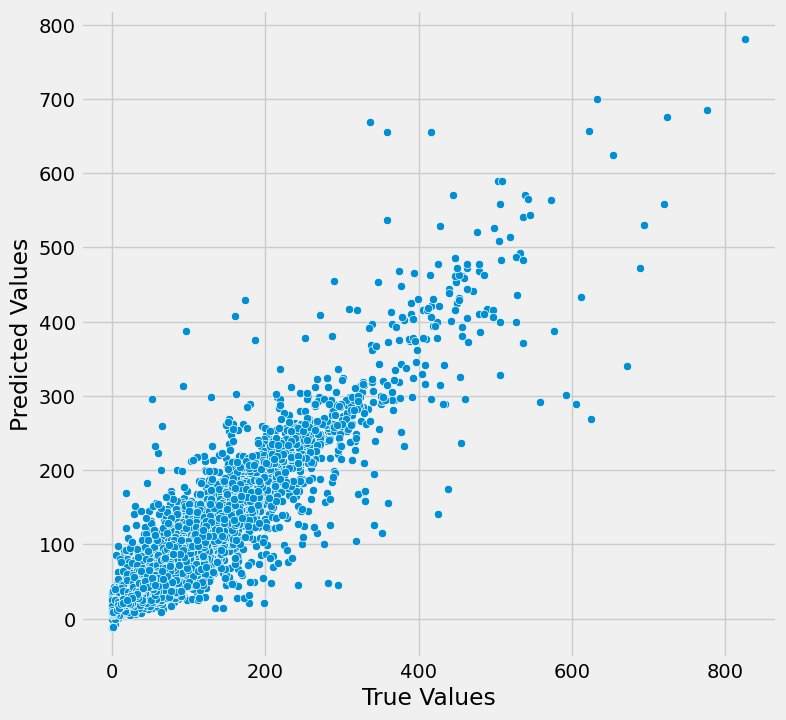

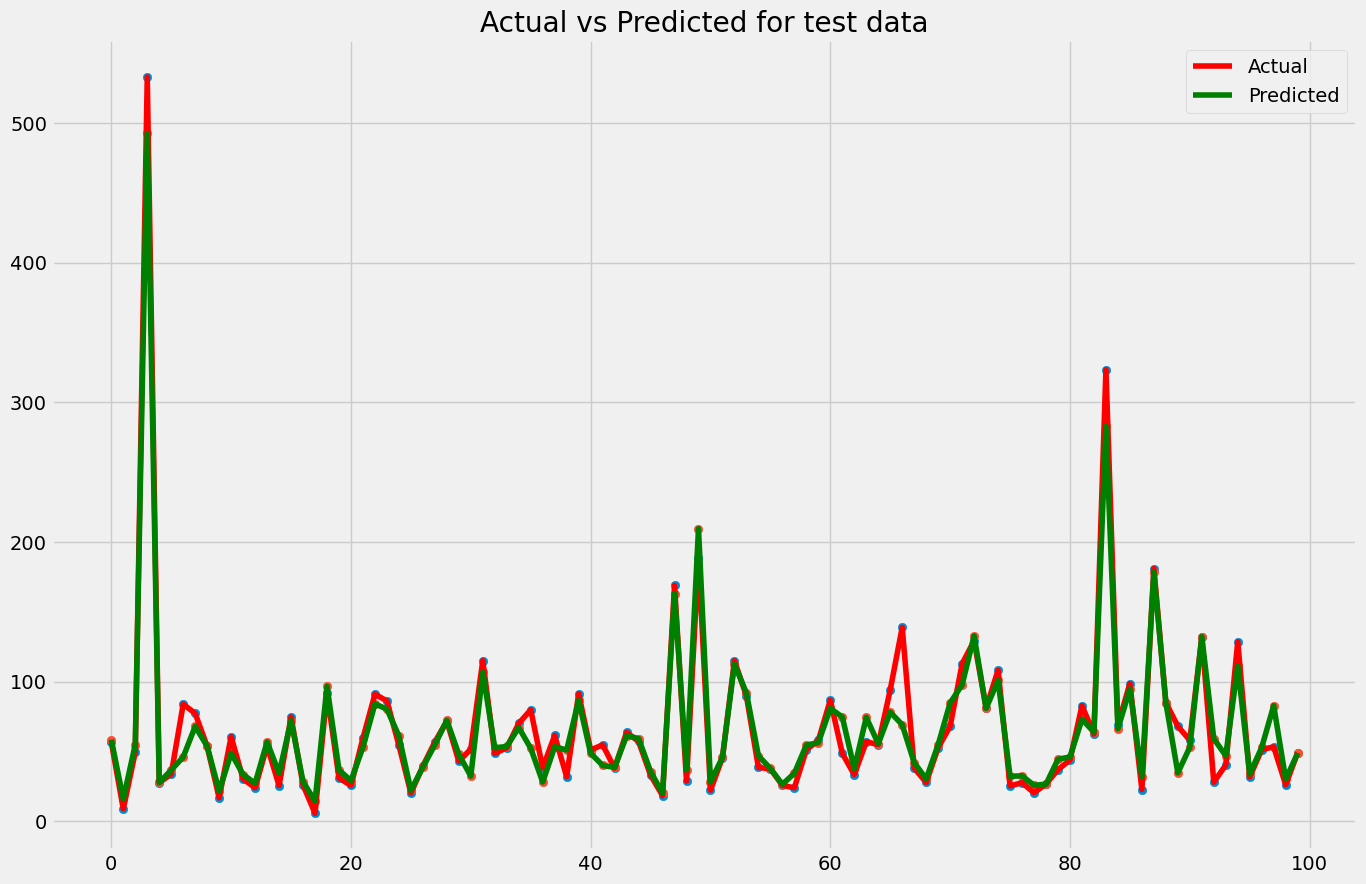

In [45]:
gb_reg=GradientBoostingRegressor(random_state=1000)
gb_reg.fit(X_train, y_train)
# Predictions
test_pred = gb_reg.predict(X_test)
train_pred = gb_reg.predict(X_train)


print('Test Dataset Score\n')
print_evaluate(y_test, test_pred)

print('=====================================\n')
print('Train Dataset Score\n')
print_evaluate(y_train, train_pred)

# Comparison of actual vs predicted results
comparison =pd.DataFrame({'True Values': y_test, 'Predicted Values': 
              test_pred})

# Scatter plot of actual vs predicted
plt.figure(figsize=(8,8))
sns.scatterplot(data=comparison, x="True Values", y="Predicted Values")
plt.show()

#actual vs predicted values comparison
plt.figure(figsize=(15,10))
plt.plot(
np.arange(len(y_test[0:100])) , y_test[0:100], "r-", label="Actual values" )
plt.plot( np.arange(len(test_pred[0:100])) , test_pred[0:100], "g-", label="Predicted values"
)
plt.scatter(
 np.arange(len(y_test[0:100])) , y_test[0:100], label="Actual values"
)
plt.scatter(
np.arange(len(test_pred[0:100])) , test_pred[0:100], label="Predicted values" )
plt.legend(['Actual', 'Predicted'])
plt.title('Actual vs Predicted for test data')


results_df = pd.DataFrame(data=[["GradientBoostingRegressor ", *evaluate(y_test, test_pred) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE','mape','r2_score'])

# model 2: RandomForestRegressor

Test Dataset Score

Mean Absolute Error 12.170516573588902
Mean Squarred Error 540.938468096421
Root Mean Squarred Error 23.25808393003218
mean_absolute_percentage_error 139416789626174.44
R2 Score: 0.8616425509852014

Train Dataset Score

Mean Absolute Error 4.5603401470429485
Mean Squarred Error 76.12398541043761
Root Mean Squarred Error 8.724906040206829
mean_absolute_percentage_error 40277688212919.49
R2 Score: 0.9809960767297133


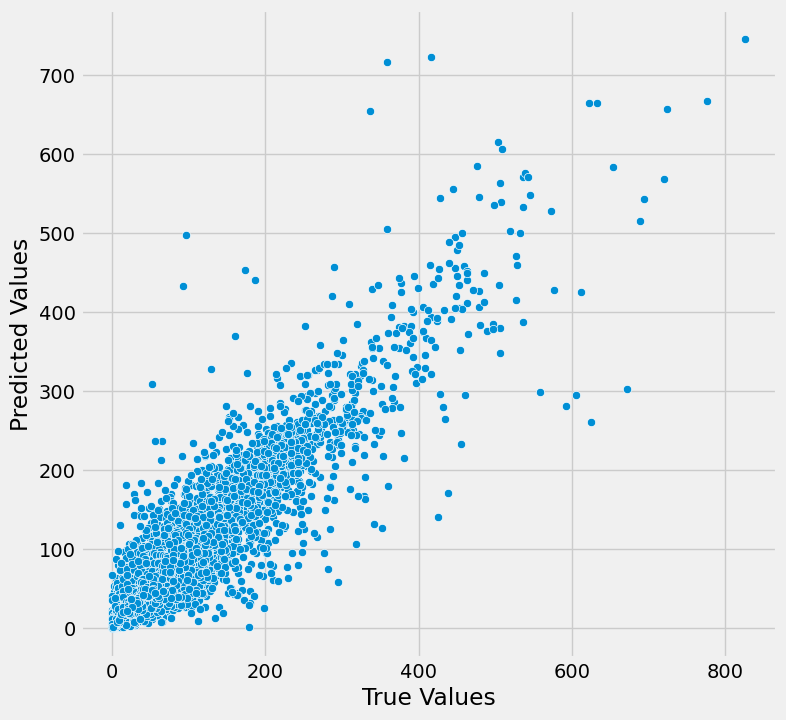

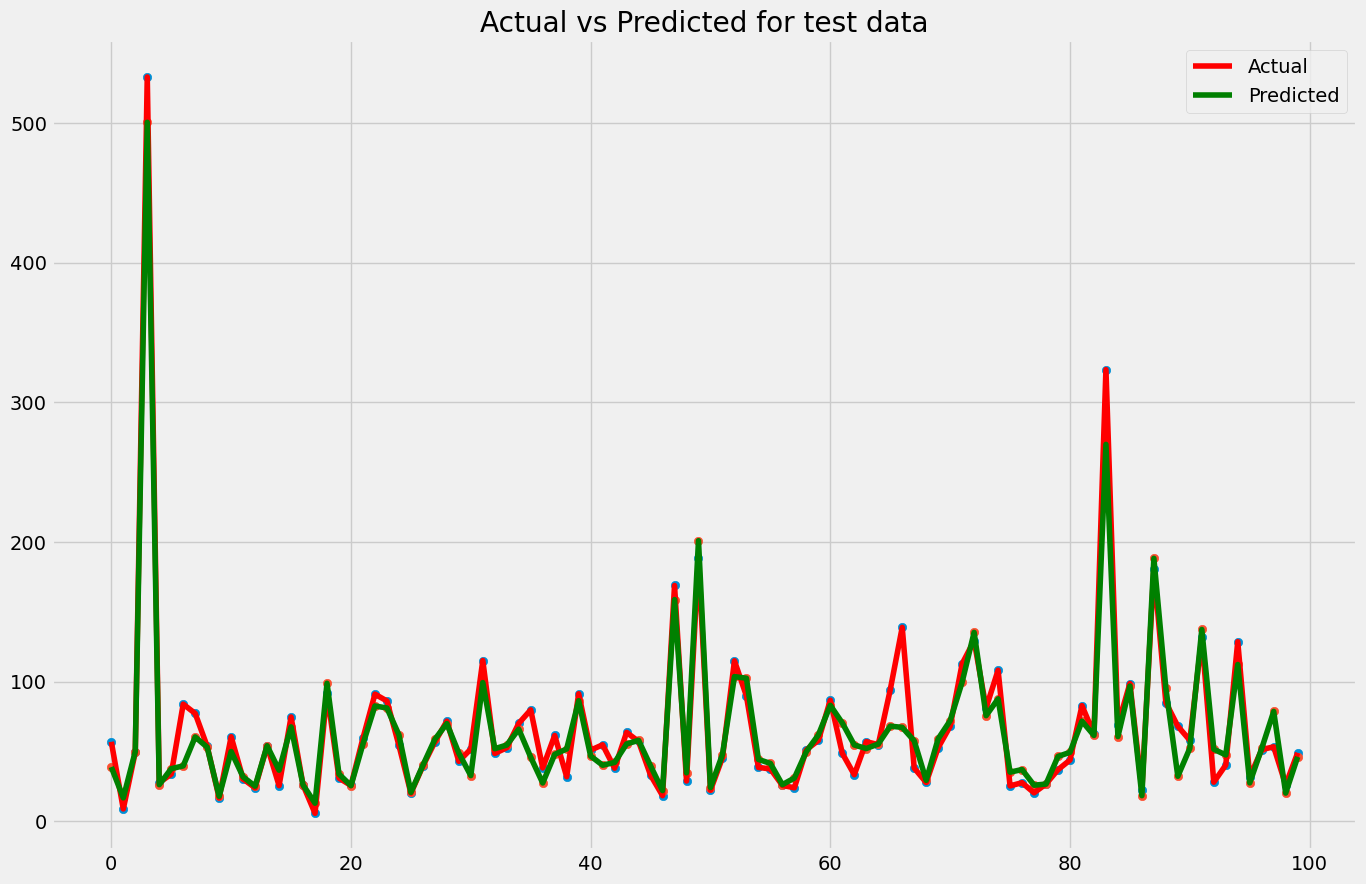

In [47]:
rf_reg=RandomForestRegressor(random_state=1000)
rf_reg.fit(X_train, y_train)
# Predictions
test_pred_rf = rf_reg.predict(X_test)
train_pred_rf = rf_reg.predict(X_train)


print('Test Dataset Score\n')
print_evaluate(y_test, test_pred_rf)

print('=====================================\n')
print('Train Dataset Score\n')
print_evaluate(y_train, train_pred_rf)

# Comparison of actual vs predicted results
comparison =pd.DataFrame({'True Values': y_test, 'Predicted Values': 
              test_pred_rf})

# Scatter plot of actual vs predicted
plt.figure(figsize=(8,8))
sns.scatterplot(data=comparison, x="True Values", y="Predicted Values")
plt.show()

#actual vs predicted values comparison
plt.figure(figsize=(15,10))
plt.plot(
np.arange(len(y_test[0:100])) , y_test[0:100], "r-", label="Actual values" )
plt.plot( np.arange(len(test_pred_rf[0:100])) , test_pred_rf[0:100], "g-", label="Predicted values"
)
plt.scatter(
 np.arange(len(y_test[0:100])) , y_test[0:100], label="Actual values"
)
plt.scatter(
np.arange(len(test_pred_rf[0:100])) , test_pred_rf[0:100], label="Predicted values" )
plt.legend(['Actual', 'Predicted'])
plt.title('Actual vs Predicted for test data')

results_df_2 = pd.DataFrame(data=[["Random forest Regression", *evaluate(y_test, test_pred_rf) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE','mape','r2_score'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)

# model 3: KNeighborsRegressor

Test Dataset Score

Mean Absolute Error 12.170516573588902
Mean Squarred Error 540.938468096421
Root Mean Squarred Error 23.25808393003218
mean_absolute_percentage_error 139416789626174.44
R2 Score: 0.8616425509852014

Train Dataset Score

Mean Absolute Error 10.057194820731933
Mean Squarred Error 324.6003825155572
Root Mean Squarred Error 18.016669573357813
mean_absolute_percentage_error 156800405276460.8
R2 Score: 0.9189653467357013


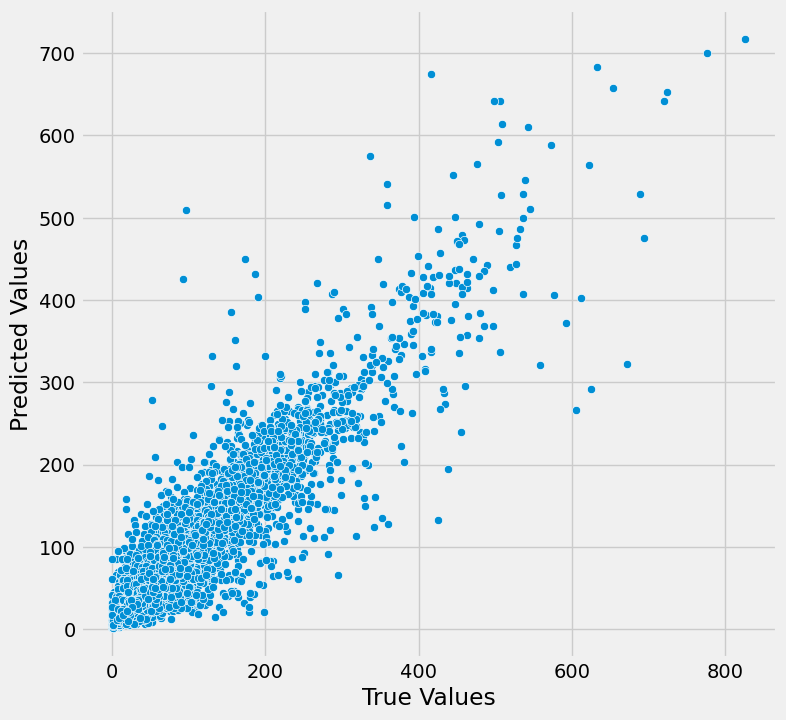

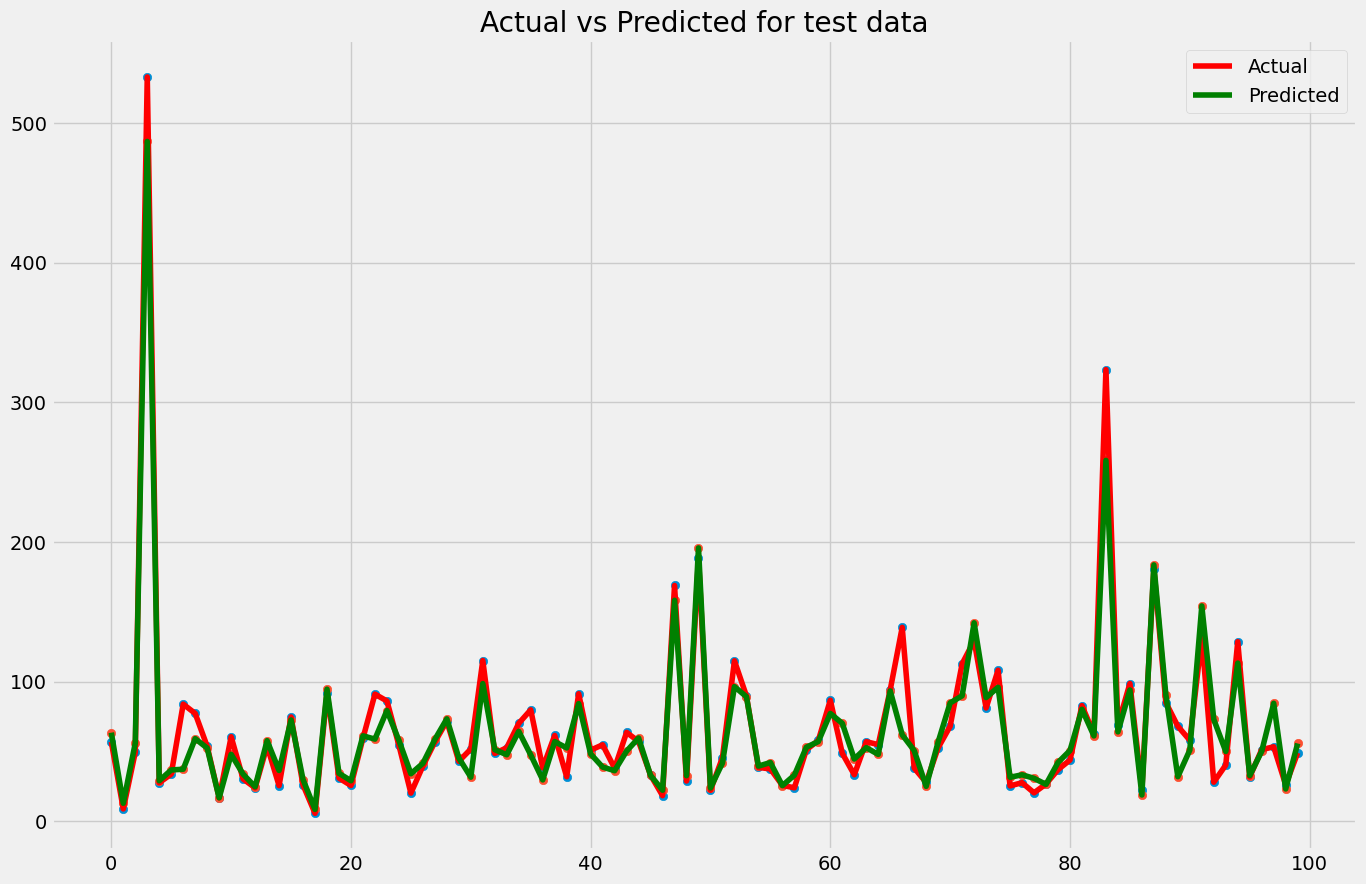

In [49]:
knn_reg=KNeighborsRegressor()
knn_reg.fit(X_train, y_train)
# Predictions
test_pred_knn = knn_reg.predict(X_test)
train_pred_knn = knn_reg.predict(X_train)


print('Test Dataset Score\n')
print_evaluate(y_test, test_pred_rf)

print('=====================================\n')
print('Train Dataset Score\n')
print_evaluate(y_train, train_pred_knn)

# Comparison of actual vs predicted results
comparison =pd.DataFrame({'True Values': y_test, 'Predicted Values': 
              test_pred_knn})

# Scatter plot of actual vs predicted
plt.figure(figsize=(8,8))
sns.scatterplot(data=comparison, x="True Values", y="Predicted Values")
plt.show()

#actual vs predicted values comparison
plt.figure(figsize=(15,10))
plt.plot(
np.arange(len(y_test[0:100])) , y_test[0:100], "r-", label="Actual values" )
plt.plot( np.arange(len(test_pred_knn[0:100])) , test_pred_knn[0:100], "g-", label="Predicted values"
)
plt.scatter(
 np.arange(len(y_test[0:100])) , y_test[0:100], label="Actual values"
)
plt.scatter(
np.arange(len(test_pred_knn[0:100])) , test_pred_knn[0:100], label="Predicted values" )
plt.legend(['Actual', 'Predicted'])
plt.title('Actual vs Predicted for test data')


results_df_2 = pd.DataFrame(data=[["KNeighborsRegressor", *evaluate(y_test, test_pred_knn) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE','mape','r2_score'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)

In [50]:
results_df

,Model,MAE,MSE,RMSE,mape,r2_score
0,GradientBoostingRegressor,10.988807,467.892314,21.630819,2.319777e+14,0.880326
1,Random forest Regression,12.170517,540.938468,23.258084,1.394168e+14,0.861643
2,KNeighborsRegressor,12.452363,538.990721,23.216174,3.563340e+14,0.862141


# hyperparameter optimization of all models using GridSearchCV

# GradientBoostingRegressor

In [53]:
parameters={"n_estimators":[100, 200, 500],
            "learning_rate" : [0.01, 0.1, 0.2],
           "max_depth":[3, 5, 7]}

# defining cross validation folds as 5
folds = 5

# Defining GridSearchCV
gb_reg=GradientBoostingRegressor(random_state=1000)
cv_model = GridSearchCV(estimator=gb_reg, param_grid=parameters, scoring='neg_mean_absolute_error', 
                        cv=folds, return_train_score=True, verbose=1)

# fiting GridSearchCV() with X_train and y_train
cv_model.fit(X_train,y_train)

# Saving GridSearchCV results into a dataframe 
cv_results = pd.DataFrame(cv_model.cv_results_)

# checking best alpha from model_cv
cv_model.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Test Dataset Score

Mean Absolute Error 10.744206982384915
Mean Squarred Error 456.74877662939105
Root Mean Squarred Error 21.37168165188203
mean_absolute_percentage_error 146567343355421.16
R2 Score: 0.8831760000403441

Train Dataset Score

Mean Absolute Error 10.01082891637423
Mean Squarred Error 318.37829629164827
Root Mean Squarred Error 17.843158248798005
mean_absolute_percentage_error 106487175485171.8
R2 Score: 0.9205186554404774


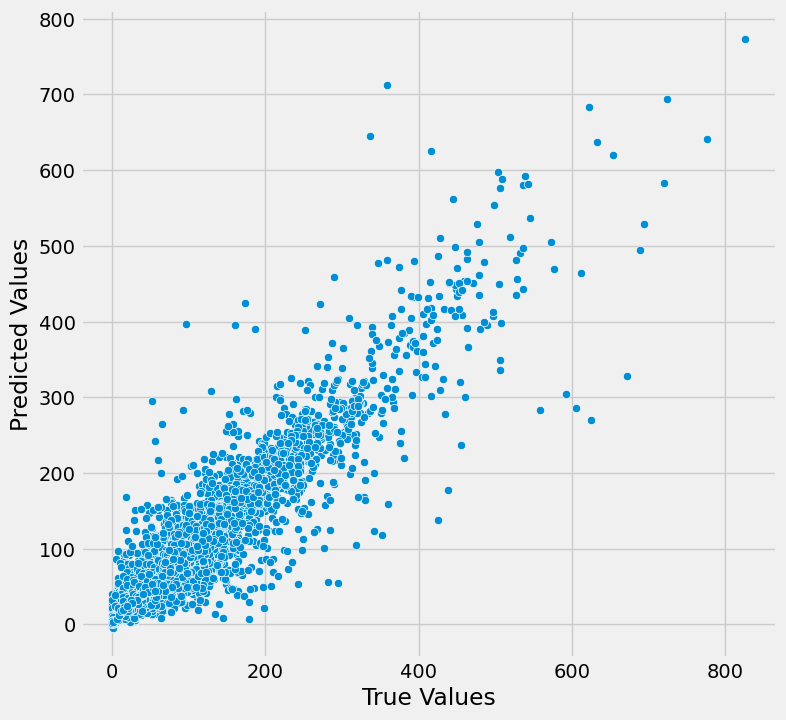

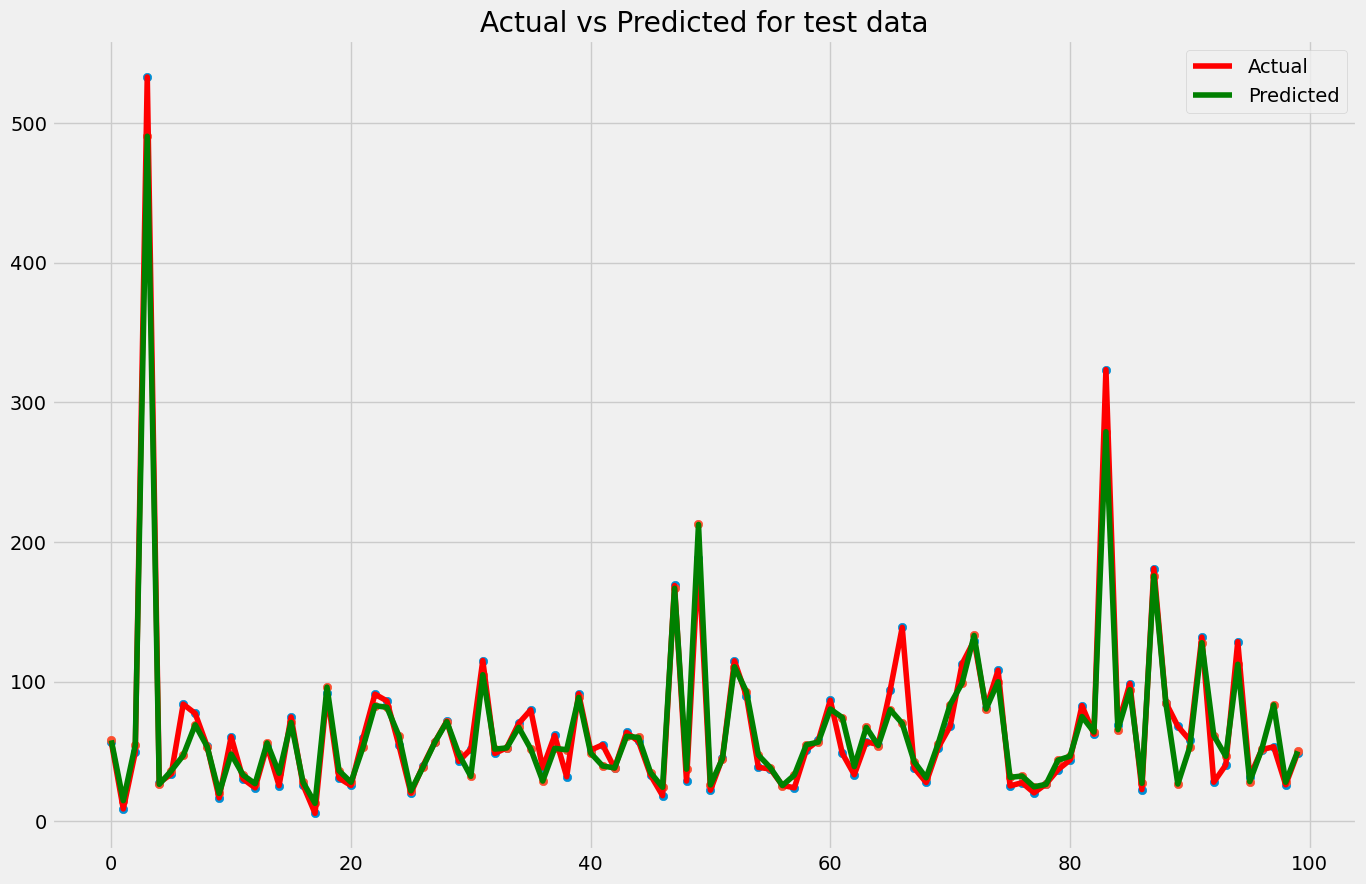

In [54]:
gb_reg = cv_model.best_estimator_
gb_reg.fit(X_train, y_train)
# Predictions
test_pred = gb_reg.predict(X_test)
train_pred = gb_reg.predict(X_train)


print('Test Dataset Score\n')
print_evaluate(y_test, test_pred)

print('=====================================\n')
print('Train Dataset Score\n')
print_evaluate(y_train, train_pred)

# Comparison of actual vs predicted results
comparison =pd.DataFrame({'True Values': y_test, 'Predicted Values': 
              test_pred})

# Scatter plot of actual vs predicted
plt.figure(figsize=(8,8))
sns.scatterplot(data=comparison, x="True Values", y="Predicted Values")
plt.show()

#actual vs predicted values comparison
plt.figure(figsize=(15,10))
plt.plot(
np.arange(len(y_test[0:100])) , y_test[0:100], "r-", label="Actual values" )
plt.plot( np.arange(len(test_pred[0:100])) , test_pred[0:100], "g-", label="Predicted values"
)
plt.scatter(
 np.arange(len(y_test[0:100])) , y_test[0:100], label="Actual values"
)
plt.scatter(
np.arange(len(test_pred[0:100])) , test_pred[0:100], label="Predicted values" )
plt.legend(['Actual', 'Predicted'])
plt.title('Actual vs Predicted for test data')


results_df = pd.DataFrame(data=[["GradientBoostingRegressor ", *evaluate(y_test, test_pred) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE','mape','r2_score'])

# RandomForestRegressor

In [56]:
parameters={'n_estimators': [100, 200, 500],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 10, 20]}

# defining cross validation folds as 5
folds = 5

# Defining GridSearchCV
rf_reg=RandomForestRegressor(random_state=1000)
cv_model2 = GridSearchCV(estimator=rf_reg, param_grid=parameters, scoring='neg_mean_absolute_error', 
                        cv=folds, return_train_score=True, verbose=1)

# fiting GridSearchCV() with X_train and y_train
cv_model2.fit(X_train,y_train)

# Saving GridSearchCV results into a dataframe 
cv_results = pd.DataFrame(cv_model2.cv_results_)

# checking best alpha from model_cv
cv_model2.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}

Test Dataset Score

Mean Absolute Error 11.029714673814558
Mean Squarred Error 492.088481594192
Root Mean Squarred Error 22.183067452320294
mean_absolute_percentage_error 125029380383668.23
R2 Score: 0.8741370580603591

Train Dataset Score

Mean Absolute Error 10.071674640761389
Mean Squarred Error 328.48396851455306
Root Mean Squarred Error 18.12412669660398
mean_absolute_percentage_error 89779514041657.36
R2 Score: 0.9179958314122386


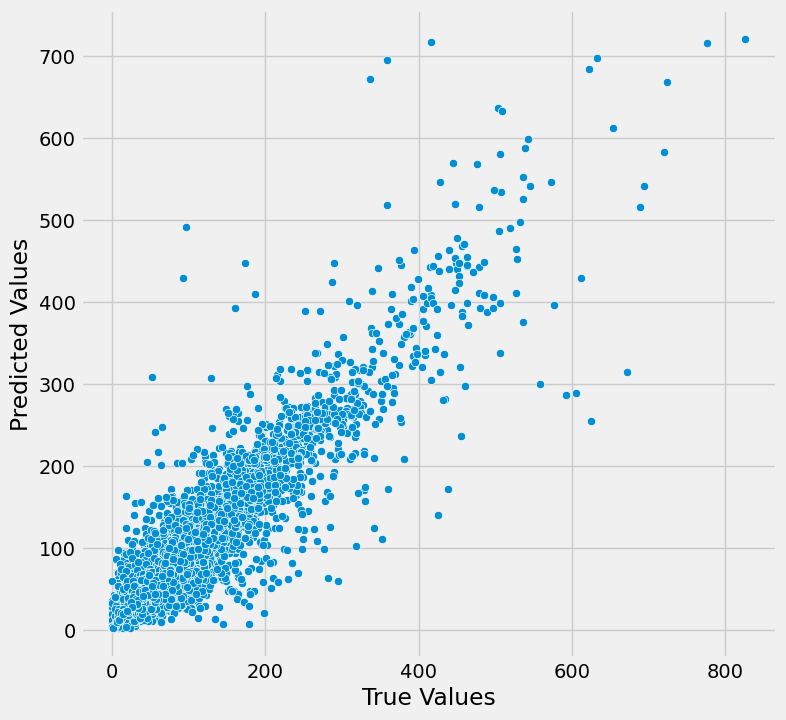

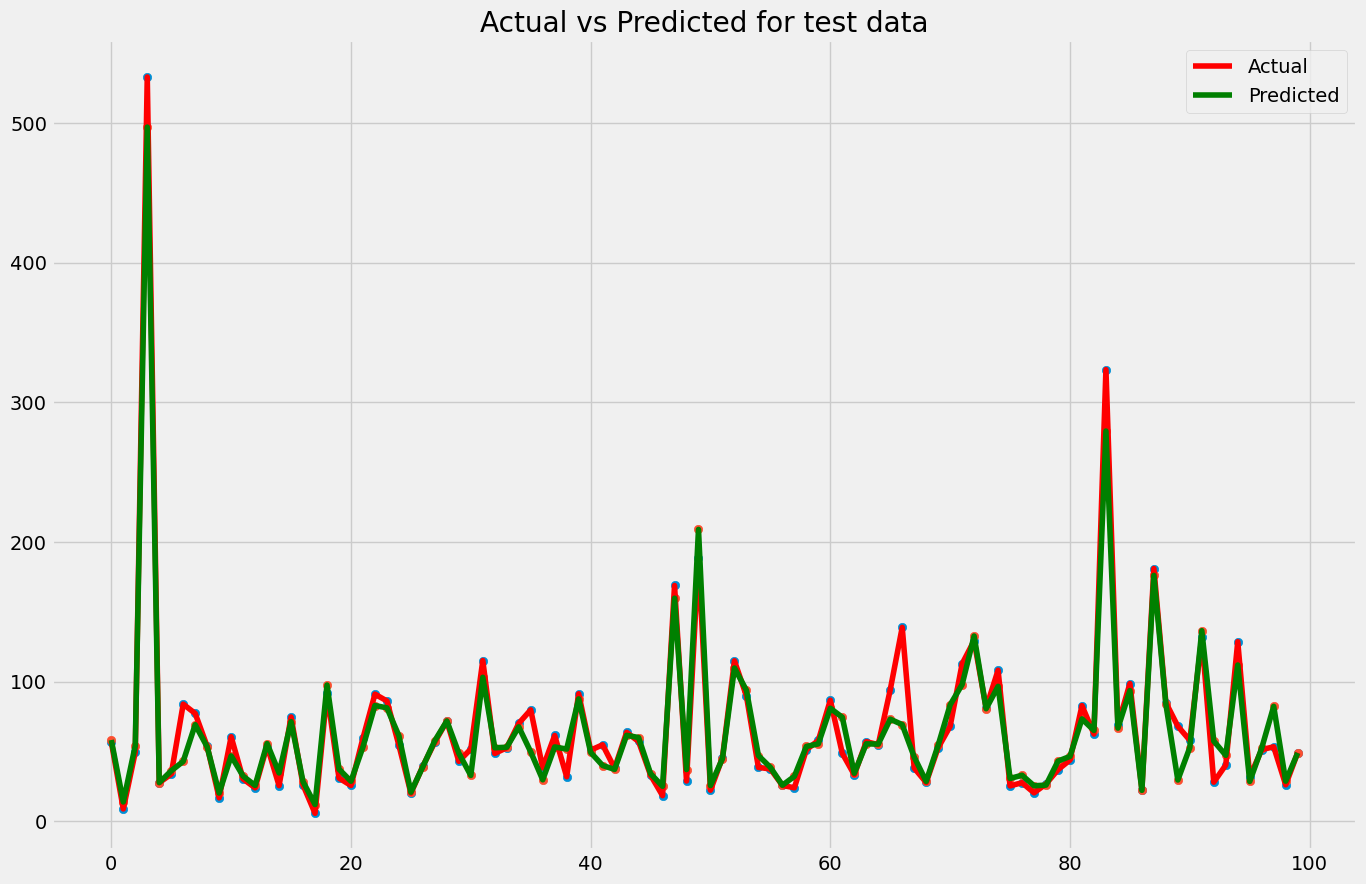

In [57]:
rf_reg = cv_model2.best_estimator_
rf_reg.fit(X_train, y_train)
# Predictions
test_pred_rf = rf_reg.predict(X_test)
train_pred_rf = rf_reg.predict(X_train)


print('Test Dataset Score\n')
print_evaluate(y_test, test_pred_rf)

print('=====================================\n')
print('Train Dataset Score\n')
print_evaluate(y_train, train_pred_rf)

# Comparison of actual vs predicted results
comparison =pd.DataFrame({'True Values': y_test, 'Predicted Values': 
              test_pred_rf})

# Scatter plot of actual vs predicted
plt.figure(figsize=(8,8))
sns.scatterplot(data=comparison, x="True Values", y="Predicted Values")
plt.show()

#actual vs predicted values comparison
plt.figure(figsize=(15,10))
plt.plot(
np.arange(len(y_test[0:100])) , y_test[0:100], "r-", label="Actual values" )
plt.plot( np.arange(len(test_pred_rf[0:100])) , test_pred_rf[0:100], "g-", label="Predicted values"
)
plt.scatter(
 np.arange(len(y_test[0:100])) , y_test[0:100], label="Actual values"
)
plt.scatter(
np.arange(len(test_pred_rf[0:100])) , test_pred_rf[0:100], label="Predicted values" )
plt.legend(['Actual', 'Predicted'])
plt.title('Actual vs Predicted for test data')

results_df_2 = pd.DataFrame(data=[["Random forest Regression", *evaluate(y_test, test_pred_rf) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE','mape','r2_score'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)

# KNeighborsRegressor

In [59]:
parameters = [{'weights': ['uniform', 'distance'], 'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 19, 21]}]
# defining cross validation folds as 5
folds = 5

# Defining GridSearchCV
knn = KNeighborsRegressor()
cv_model3 = GridSearchCV(estimator=knn, param_grid=parameters, scoring='neg_mean_absolute_error', 
                        cv=folds, return_train_score=True, verbose=1)

# fiting GridSearchCV() with X_train and y_train
cv_model3.fit(X_train,y_train)

# Saving GridSearchCV results into a dataframe 
cv_results = pd.DataFrame(cv_model3.cv_results_)

# checking best alpha from model_cv
cv_model3.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'n_neighbors': 9, 'weights': 'uniform'}

Test Dataset Score

Mean Absolute Error 11.029714673814558
Mean Squarred Error 492.088481594192
Root Mean Squarred Error 22.183067452320294
mean_absolute_percentage_error 125029380383668.23
R2 Score: 0.8741370580603591

Train Dataset Score

Mean Absolute Error 10.675810630082799
Mean Squarred Error 379.6277772381892
Root Mean Squarred Error 19.4840390380996
mean_absolute_percentage_error 218818170215797.97
R2 Score: 0.9052280682493691


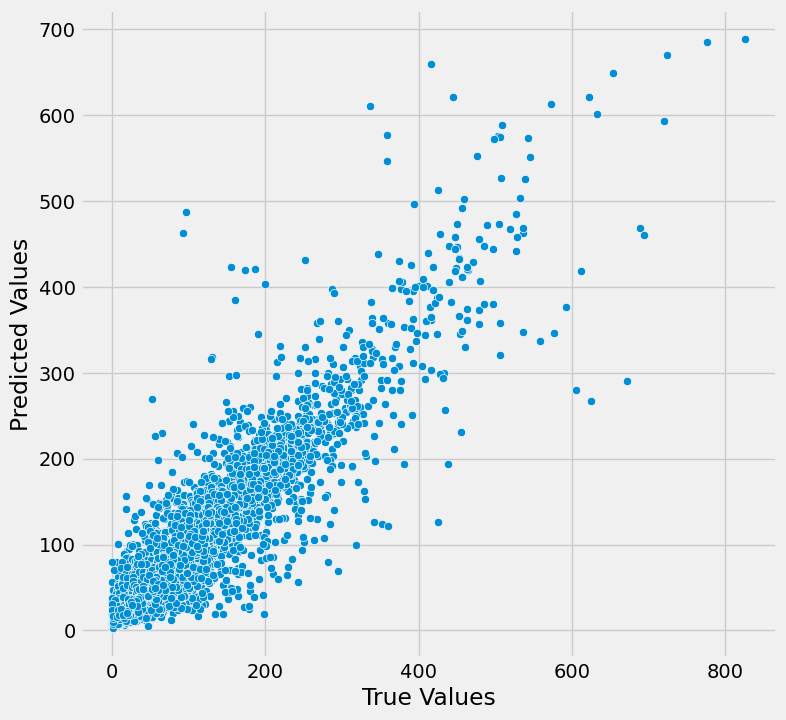

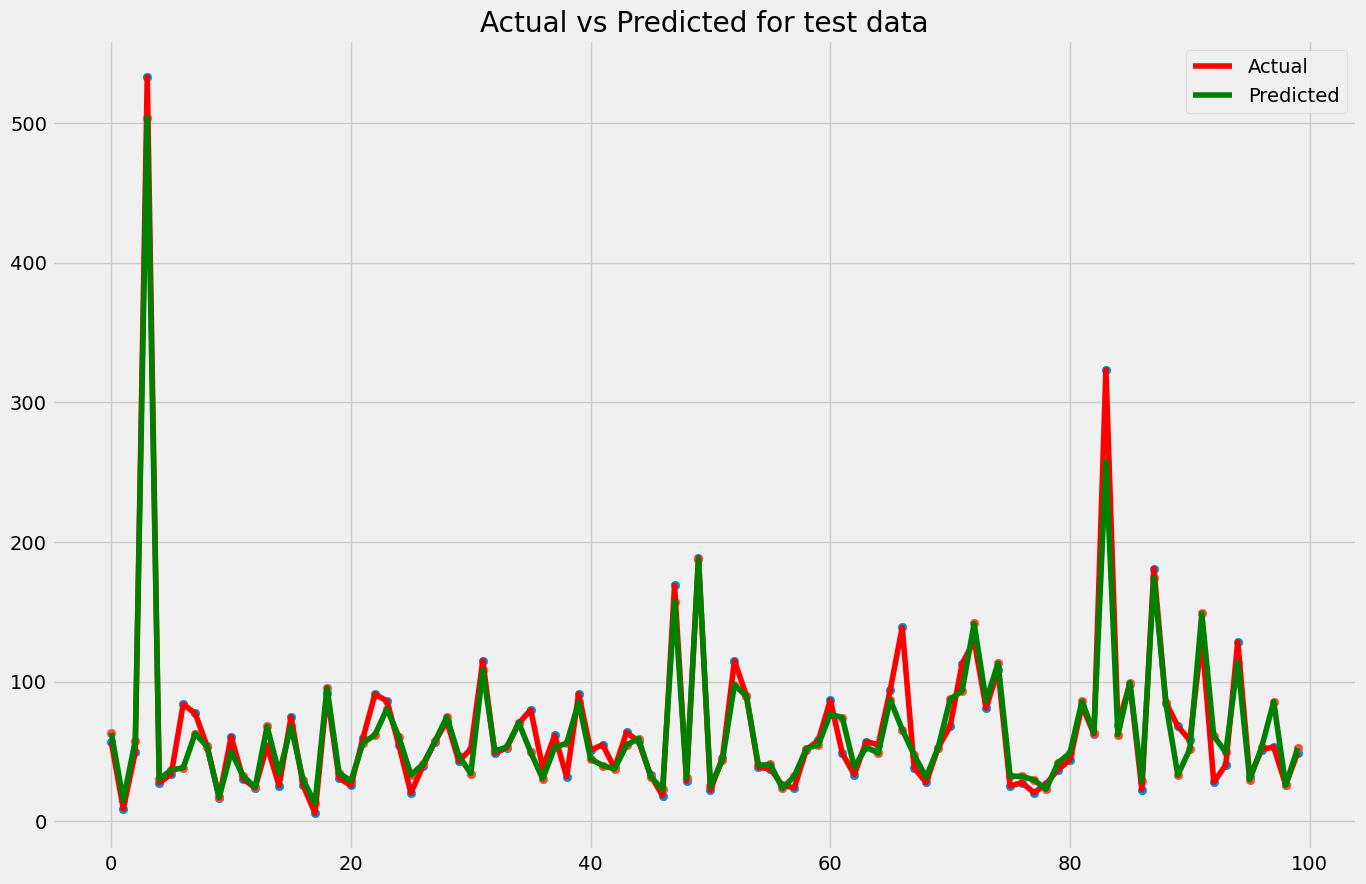

In [60]:
knn_reg=cv_model3.best_estimator_
knn_reg.fit(X_train, y_train)
# Predictions
test_pred_knn = knn_reg.predict(X_test)
train_pred_knn = knn_reg.predict(X_train)


print('Test Dataset Score\n')
print_evaluate(y_test, test_pred_rf)

print('=====================================\n')
print('Train Dataset Score\n')
print_evaluate(y_train, train_pred_knn)

# Comparison of actual vs predicted results
comparison =pd.DataFrame({'True Values': y_test, 'Predicted Values': 
              test_pred_knn})

# Scatter plot of actual vs predicted
plt.figure(figsize=(8,8))
sns.scatterplot(data=comparison, x="True Values", y="Predicted Values")
plt.show()

#actual vs predicted values comparison
plt.figure(figsize=(15,10))
plt.plot(
np.arange(len(y_test[0:100])) , y_test[0:100], "r-", label="Actual values" )
plt.plot( np.arange(len(test_pred_knn[0:100])) , test_pred_knn[0:100], "g-", label="Predicted values"
)
plt.scatter(
 np.arange(len(y_test[0:100])) , y_test[0:100], label="Actual values"
)
plt.scatter(
np.arange(len(test_pred_knn[0:100])) , test_pred_knn[0:100], label="Predicted values" )
plt.legend(['Actual', 'Predicted'])
plt.title('Actual vs Predicted for test data')


results_df_2 = pd.DataFrame(data=[["KNeighborsRegressor", *evaluate(y_test, test_pred_knn) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE','mape','r2_score'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)

In [61]:
results_df

,Model,MAE,MSE,RMSE,mape,r2_score
0,GradientBoostingRegressor,10.744207,456.748777,21.371682,1.465673e+14,0.883176
1,Random forest Regression,11.029715,492.088482,22.183067,1.250294e+14,0.874137
2,KNeighborsRegressor,12.106728,529.748904,23.016275,4.179088e+14,0.864505
